#### Library import

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [14]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [15]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [16]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9775292424254468416
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2445530478520034701
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [17]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [18]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [19]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [20]:
As = data
Cd = data
Ni = data

In [21]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [22]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [23]:
import smogn

In [24]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   1%|1         | 2/148 [00:00<00:11, 12.66it/s]

r_index: 100%|##########| 91/91 [00:00<00:00, 439.52it/s]


In [25]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [26]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [27]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [28]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [29]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [30]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(876, 15)
(1237, 15)
(1095, 15)


StandardScaler

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [32]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42) '

MinMaxScaler

In [33]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [34]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(700, 15)
(989, 15)
(876, 15)


#### 10-Fold Crossvalidation

In [35]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [36]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [37]:
from sklearn.model_selection import cross_val_score

def objectiveLGBM(trial: Trial, X_train, y_train) -> float:
    lgbm_paramas = {
        "random_state": 42,
        "learning_rate": 0.1, 
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "num_iterations": trial.suggest_int("num_iterations", 500, 1000)
    }
    
    lgbm = LGBMRegressor(**lgbm_paramas)
    r2 = cross_val_score(lgbm, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [38]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:06:16,168] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:06:20,763] Trial 0 finished with value: 0.4275140337219221 and parameters: {'n_estimators': 945, 'max_depth': 27, 'num_leaves': 25, 'min_child_samples': 6, 'num_iterations': 871}. Best is trial 0 with value: 0.4275140337219221.
[I 2023-08-24 14:06:23,357] Trial 1 finished with value: 0.4331820219031977 and parameters: {'n_estimators': 875, 'max_depth': 28, 'num_leaves': 16, 'min_child_samples': 3, 'num_iterations': 673}. Best is trial 1 with value: 0.4331820219031977.
[I 2023-08-24 14:06:26,418] Trial 2 finished with value: 0.4489951581198409 and parameters: {'n_estimators': 749, 'max_depth': 28, 'num_leaves': 14, 'min_child_samples': 3, 'num_iterations': 891}. Best is trial 2 with value: 0.4489951581198409.
[I 2023-08-24 14:06:28,576] Trial 3 finished with value: 0.4194281532982539 and parameters: {'n_estimators': 796, 'max_depth': 22, 'num_leaves': 19, 'min_child_samples': 6, 'num

Best r2:  0.4898396149904357
Best trial: {'n_estimators': 742, 'max_depth': 23, 'num_leaves': 5, 'min_child_samples': 1, 'num_iterations': 661}


In [39]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 742, 'max_depth': 23, 'num_leaves': 5, 'min_child_samples': 1, 'num_iterations': 661}


In [41]:
study.best_trial.params["n_estimators"]

742

In [42]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=23, min_child_samples=1, n_estimators=742,
              num_iterations=661, num_leaves=5, random_state=42)

In [43]:
y_train_pred = lgbm.predict(As_X_train)
y_test_pred = lgbm.predict(As_X_test)

In [44]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [45]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.105564146786757
Test RMSE:  0.4904763771499332


In [46]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9545362964536456
Test R2:  -0.04691957724697482


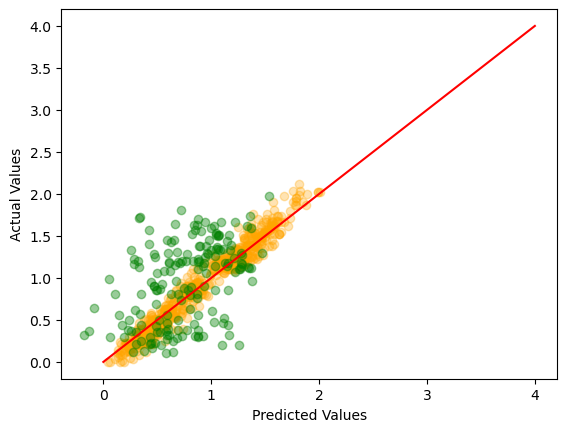

In [47]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [48]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:08:57,020] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:08:59,189] Trial 0 finished with value: 0.6000793765919229 and parameters: {'n_estimators': 916, 'max_depth': 27, 'num_leaves': 11, 'min_child_samples': 6, 'num_iterations': 835}. Best is trial 0 with value: 0.6000793765919229.
[I 2023-08-24 14:09:03,751] Trial 1 finished with value: 0.6055882108673565 and parameters: {'n_estimators': 968, 'max_depth': 20, 'num_leaves': 23, 'min_child_samples': 2, 'num_iterations': 843}. Best is trial 1 with value: 0.6055882108673565.
[I 2023-08-24 14:09:05,124] Trial 2 finished with value: 0.6033846916996287 and parameters: {'n_estimators': 851, 'max_depth': 29, 'num_leaves': 10, 'min_child_samples': 9, 'num_iterations': 587}. Best is trial 1 with value: 0.6055882108673565.
[I 2023-08-24 14:09:09,479] Trial 3 finished with value: 0.5916123949115615 and parameters: {'n_estimators': 855, 'max_depth': 25, 'num_leaves': 26, 'min_child_samples': 6, 'num

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:09:22,833] Trial 7 finished with value: 0.5873752677147069 and parameters: {'n_estimators': 893, 'max_depth': 29, 'num_leaves': 31, 'min_child_samples': 8, 'num_iterations': 939}. Best is trial 1 with value: 0.6055882108673565.
[I 2023-08-24 14:09:25,594] Trial 8 finished with value: 0.6061207942173475 and parameters: {'n_estimators': 621, 'max_depth': 23, 'num_leaves': 17, 'min_child_samples': 2, 'num_iterations': 742}. Best is trial 8 with value: 0.6061207942173475.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:09:29,777] Trial 9 finished with value: 0.5969922235286764 and parameters: {'n_estimators': 968, 'max_depth': 27, 'num_leaves': 31, 'min_child_samples': 3, 'num_iterations': 663}. Best is trial 8 with value: 0.6061207942173475.
[I 2023-08-24 14:09:30,474] Trial 10 finished with value: 0.5869285001751722 and parameters: {'n_estimators': 707, 'max_depth': 12, 'num_leaves': 5, 'min_child_samples': 1, 'num_iterations': 525}. Best is trial 8 with value: 0.6061207942173475.
[I 2023-08-24 14:09:34,620] Trial 11 finished with value: 0.5962391313170612 and parameters: {'n_estimators': 726, 'max_depth': 19, 'num_leaves': 20, 'min_child_samples': 1, 'num_iterations': 887}. Best is trial 8 with value: 0.6061207942173475.
[I 2023-08-24 14:09:36,653] Trial 12 finished with value: 0.6094512121226422 and parameters: {'n_estimators': 524, 'max_depth': 19, 'num_leaves': 13, 'min_child_samples': 3, 'num_iterations': 724}. Best is trial 12 with value: 0.6094512121226422.
[I 2023-08-24 14:

Best r2:  0.6175313058298373
Best trial: {'n_estimators': 858, 'max_depth': 23, 'num_leaves': 6, 'min_child_samples': 7, 'num_iterations': 614}


In [49]:
optuna.visualization.plot_parallel_coordinate(study)

In [50]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 858, 'max_depth': 23, 'num_leaves': 6, 'min_child_samples': 7, 'num_iterations': 614}


858

In [51]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=23, min_child_samples=7, n_estimators=858,
              num_iterations=614, num_leaves=6, random_state=42)

In [52]:
y_train_pred = lgbm.predict(Cd_X_train)
y_test_pred = lgbm.predict(Cd_X_test)

In [53]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.020041057451875427
Test RMSE:  0.08322912775070444


In [54]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9462320743871582
Test R2:  0.0703991170584739


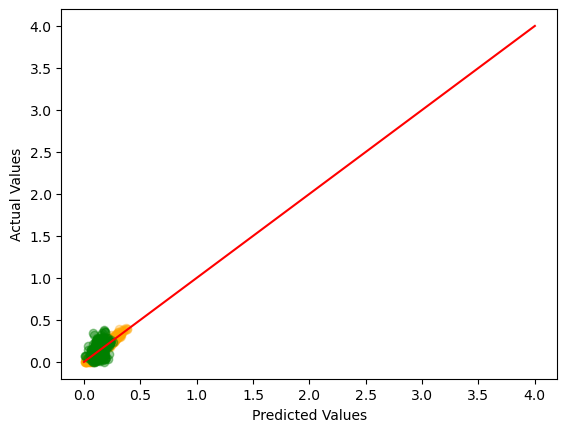

In [55]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4], [0, 4], color='red', linestyle='-')

plt.show()

Ni

In [56]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:11:36,105] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-24 14:11:39,288] Trial 0 finished with value: 0.7947900713588125 and parameters: {'n_estimators': 542, 'max_depth': 22, 'num_leaves': 25, 'min_child_samples': 10, 'num_iterations': 579}. Best is trial 0 with value: 0.7947900713588125.
[I 2023-08-24 14:11:42,554] Trial 1 finished with value: 0.7887353824839647 and parameters: {'n_estimators': 546, 'max_depth': 15, 'num_leaves': 23, 'min_child_samples': 2, 'num_iterations': 592}. Best is trial 0 with value: 0.7947900713588125.
[I 2023-08-24 14:11:42,923] Trial 2 finished with value: 0.6852543686661827 and parameters: {'n_estimators': 776, 'max_depth': 1, 'num_leaves': 13, 'min_child_samples': 1, 'num_iterations': 573}. Best is trial 0 with value: 0.7947900713588125.
[I 2023-08-24 14:11:46,924] Trial 3 finished with value: 0.7978884283348332 and parameters: {'n_estimators': 617, 'max_depth': 28, 'num_leaves': 20, 'min_child_samples': 9, 'num

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:11:58,507] Trial 10 finished with value: 0.7985644002893418 and parameters: {'n_estimators': 660, 'max_depth': 28, 'num_leaves': 31, 'min_child_samples': 7, 'num_iterations': 991}. Best is trial 10 with value: 0.7985644002893418.
[I 2023-08-24 14:12:01,600] Trial 11 finished with value: 0.791336371326201 and parameters: {'n_estimators': 685, 'max_depth': 30, 'num_leaves': 32, 'min_child_samples': 7, 'num_iterations': 967}. Best is trial 10 with value: 0.7985644002893418.
[I 2023-08-24 14:12:02,194] Trial 12 finished with value: 0.7745494041485985 and parameters: {'n_estimators': 664, 'max_depth': 30, 'num_leaves': 4, 'min_child_samples': 8, 'num_iterations': 991}. Best is trial 10 with value: 0.7985644002893418.
[I 2023-08-24 14:12:03,934] Trial 13 finished with value: 0.7896039384247371 and parameters: {'n_estimators': 623, 'max_depth': 24, 'num_leaves': 18, 'min_child_samples': 7, 'num_iterations': 896}. Best is trial 10 with value: 0.7985644002893418.
[I 2023-08-24 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:03,260] Trial 53 finished with value: 0.8040479341214842 and parameters: {'n_estimators': 926, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 8, 'num_iterations': 648}. Best is trial 20 with value: 0.8051265905838971.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:04,798] Trial 54 finished with value: 0.8071584724012422 and parameters: {'n_estimators': 927, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 647}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:06,031] Trial 55 finished with value: 0.7972833307918586 and parameters: {'n_estimators': 929, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 545}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:08,195] Trial 56 finished with value: 0.8052134546276518 and parameters: {'n_estimators': 860, 'max_depth': 11, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 702}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:10,395] Trial 57 finished with value: 0.8034760267631416 and parameters: {'n_estimators': 859, 'max_depth': 12, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 706}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:12,545] Trial 58 finished with value: 0.796454488328233 and parameters: {'n_estimators': 858, 'max_depth': 13, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 705}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:14,937] Trial 59 finished with value: 0.8011816216625707 and parameters: {'n_estimators': 837, 'max_depth': 12, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 759}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:17,686] Trial 60 finished with value: 0.8033799671824073 and parameters: {'n_estimators': 817, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 794}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:20,467] Trial 61 finished with value: 0.8041955739984029 and parameters: {'n_estimators': 822, 'max_depth': 20, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 836}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:23,284] Trial 62 finished with value: 0.8033615890827364 and parameters: {'n_estimators': 816, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 832}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:26,181] Trial 63 finished with value: 0.7910984319227264 and parameters: {'n_estimators': 814, 'max_depth': 18, 'num_leaves': 32, 'min_child_samples': 10, 'num_iterations': 846}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:27,493] Trial 64 finished with value: 0.7938674864551436 and parameters: {'n_estimators': 747, 'max_depth': 23, 'num_leaves': 14, 'min_child_samples': 9, 'num_iterations': 796}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:30,091] Trial 65 finished with value: 0.7941369405593622 and parameters: {'n_estimators': 862, 'max_depth': 21, 'num_leaves': 28, 'min_child_samples': 10, 'num_iterations': 863}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:37,119] Trial 68 finished with value: 0.7938025962499599 and parameters: {'n_estimators': 826, 'max_depth': 22, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 803}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:40,055] Trial 69 finished with value: 0.8022985927819717 and parameters: {'n_estimators': 783, 'max_depth': 14, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 882}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:42,595] Trial 70 finished with value: 0.8024462772838893 and parameters: {'n_estimators': 894, 'max_depth': 16, 'num_leaves': 29, 'min_child_samples': 8, 'num_iterations': 828}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:45,529] Trial 71 finished with value: 0.8041954831849087 and parameters: {'n_estimators': 808, 'max_depth': 20, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 860}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:48,477] Trial 72 finished with value: 0.7982607604625811 and parameters: {'n_estimators': 802, 'max_depth': 18, 'num_leaves': 30, 'min_child_samples': 9, 'num_iterations': 849}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:48,821] Trial 73 finished with value: 0.7031833340899777 and parameters: {'n_estimators': 756, 'max_depth': 20, 'num_leaves': 2, 'min_child_samples': 3, 'num_iterations': 906}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:13:51,987] Trial 74 finished with value: 0.8039199056340817 and parameters: {'n_estimators': 844, 'max_depth': 25, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 930}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:54,808] Trial 75 finished with value: 0.7983851260035643 and parameters: {'n_estimators': 844, 'max_depth': 24, 'num_leaves': 27, 'min_child_samples': 8, 'num_iterations': 949}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:13:57,856] Trial 76 finished with value: 0.7897761558570057 and parameters: {'n_estimators': 859, 'max_depth': 29, 'num_leaves': 32, 'min_child_samples': 10, 'num_iterations': 921}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:00,850] Trial 77 finished with value: 0.8011220107040368 and parameters: {'n_estimators': 871, 'max_depth': 26, 'num_leaves': 28, 'min_child_samples': 8, 'num_iterations': 992}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:08,546] Trial 80 finished with value: 0.7979480806795982 and parameters: {'n_estimators': 847, 'max_depth': 14, 'num_leaves': 31, 'min_child_samples': 8, 'num_iterations': 977}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:11,446] Trial 81 finished with value: 0.8039474602415531 and parameters: {'n_estimators': 815, 'max_depth': 22, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 875}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:14,414] Trial 82 finished with value: 0.7957141618101686 and parameters: {'n_estimators': 830, 'max_depth': 22, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 868}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:17,248] Trial 83 finished with value: 0.7971479215511758 and parameters: {'n_estimators': 794, 'max_depth': 24, 'num_leaves': 30, 'min_child_samples': 9, 'num_iterations': 888}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:19,584] Trial 84 finished with value: 0.7939181892932495 and parameters: {'n_estimators': 802, 'max_depth': 25, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 689}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:21,711] Trial 85 finished with value: 0.798973953424291 and parameters: {'n_estimators': 885, 'max_depth': 23, 'num_leaves': 29, 'min_child_samples': 9, 'num_iterations': 647}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:24,346] Trial 86 finished with value: 0.798391332474086 and parameters: {'n_estimators': 736, 'max_depth': 27, 'num_leaves': 27, 'min_child_samples': 8, 'num_iterations': 909}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:26,519] Trial 87 finished with value: 0.8028177510929837 and parameters: {'n_estimators': 709, 'max_depth': 8, 'num_leaves': 30, 'min_child_samples': 9, 'num_iterations': 938}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:33,887] Trial 91 finished with value: 0.8033721851530341 and parameters: {'n_estimators': 812, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 815}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:36,704] Trial 92 finished with value: 0.8033476055650471 and parameters: {'n_estimators': 866, 'max_depth': 19, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 854}. Best is trial 54 with value: 0.8071584724012422.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:39,508] Trial 93 finished with value: 0.8019734498432449 and parameters: {'n_estimators': 849, 'max_depth': 17, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 838}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:41,635] Trial 94 finished with value: 0.8032342389900288 and parameters: {'n_estimators': 790, 'max_depth': 22, 'num_leaves': 29, 'min_child_samples': 8, 'num_iterations': 668}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:44,292] Trial 95 finished with value: 0.7958075423174359 and parameters: {'n_estimators': 818, 'max_depth': 21, 'num_leaves': 32, 'min_child_samples': 9, 'num_iterations': 786}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24 14:14:46,052] Trial 96 finished with value: 0.796924121733245 and parameters: {'n_estimators': 944, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 10, 'num_iterations': 879}. Best is trial 54 with value: 0.8071584724012422.
[I 2023-08-24

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-24 14:14:52,182] Trial 99 finished with value: 0.7976756826895326 and parameters: {'n_estimators': 872, 'max_depth': 10, 'num_leaves': 31, 'min_child_samples': 6, 'num_iterations': 635}. Best is trial 54 with value: 0.8071584724012422.


Best r2:  0.8071584724012422
Best trial: {'n_estimators': 927, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 647}


In [57]:
optuna.visualization.plot_parallel_coordinate(study)

In [58]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 927, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 9, 'num_iterations': 647}


927

In [59]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Ni_X_train, Ni_y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=8, min_child_samples=9, n_estimators=927,
              num_iterations=647, random_state=42)

In [60]:
y_train_pred = lgbm.predict(Ni_X_train)
y_test_pred = lgbm.predict(Ni_X_test)

In [61]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.016668731178507114
Test RMSE:  0.685631763830245


In [62]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9998166855196098
Test R2:  0.6555555612535807


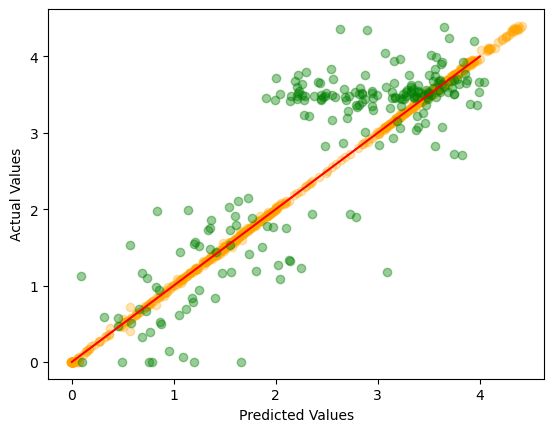

In [63]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()